# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('facial-keypoints-detection/training.csv')

In [3]:
y_full = df.drop(columns=['Image']).values.astype(np.float32)
x_full = [[int(n) for n in img_str.split()] for img_str in df['Image']]
x_full = np.array(x_full, dtype=np.float32).reshape((-1, 96, 96, 1)) / 255

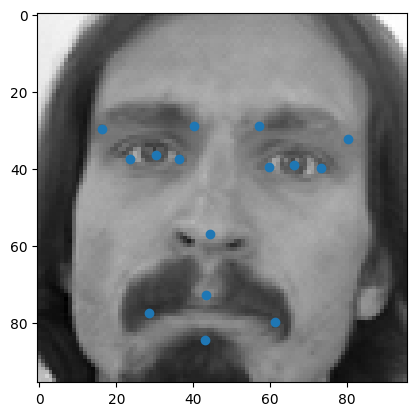

In [4]:
plt.imshow(x_full[0], cmap='grey')
key_points = y_full[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_full, 
    y_full,
    test_size=0.125,
    shuffle=True,
    random_state=0,
)

imputer = KNNImputer()
y_train_full = imputer.fit_transform(y_train_full)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, 
    y_train_full,
    test_size=0.15,
    shuffle=True,
    random_state=0,
)

print(f'{len(x_train)} train, {len(x_valid)} valid, {len(x_test)} test')

5241 train, 926 valid, 882 test


# Model

In [110]:
import tensorflow as tf
import keras
from keras import models, layers, losses, optimizers

In [117]:
model = models.Sequential((
    layers.Input(shape=(96, 96, 1)),
    layers.Conv2D(64, (3, 3), 
                  padding='same', 
                  activation=tf.nn.relu, 
                  use_bias=False),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3),
                  padding='same', 
                  activation=tf.nn.relu, 
                  use_bias=False),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), 
                  padding='same', 
                  activation=tf.nn.relu, 
                  use_bias=False),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(30),
))

model.compile(loss=losses.mean_squared_error, metrics=[tf.metrics.R2Score()])

optimizer = optimizers.Adam(learning_rate=0.001, weight_decay=0.1)


def batch_iterate(x, y, batch_size):
    permutation = np.random.permutation(y.shape[0])
    for s in range(0, y.shape[0], batch_size):
        idxs = permutation[s:s + batch_size]
        yield tf.convert_to_tensor(x[idxs]), tf.convert_to_tensor(y[idxs])
        

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        l = model.loss(y, y_pred)
    grads = tape.gradient(l, model.trainable_variables)
    optimizer.apply(grads, model.trainable_variables)

In [118]:
for _ in range(10):
    for xb, yb in batch_iterate(x_train, y_train, batch_size=100):
        train_step(xb, yb)
    optimizer.learning_rate *= 0.99

In [119]:
_ = model.evaluate(x_valid, y_valid)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 11.1371 - r2_score: -0.0518


In [ ]:
class CustomModel(keras.Model):
    def fit(self, x, y, batch_size=32, epochs=1):
        def batch_iterate():
            permutation = np.random.permutation(y.shape[0])
            for s in range(0, y.shape[0], batch_size):
                idxs = permutation[s:s + batch_size]
                yield tf.convert_to_tensor(x[idxs]), tf.convert_to_tensor(y[idxs])
                

        @tf.function
        def train_step(xb, yb):
            with tf.GradientTape() as tape:
                y_pred = self(xb)
                l = self.loss(yb, y_pred)
            grads = tape.gradient(l, self.trainable_variables)
            self.optimizer.apply(grads, self.trainable_variables)


        for _ in range(epochs):
            for xb, yb in batch_iterate():
                train_step(xb, yb)
            self.optimizer.learning_rate *= 0.99

In [124]:
model_in = layers.Input(shape=(96, 96, 1))
sequential = models.Sequential((
    layers.Conv2D(64, (3, 3), 
                  padding='same', 
                  activation=tf.nn.relu, 
                  use_bias=False),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3),
                  padding='same', 
                  activation=tf.nn.relu, 
                  use_bias=False),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), 
                  padding='same', 
                  activation=tf.nn.relu, 
                  use_bias=False),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(30),
))(model_in)

model = CustomModel(model_in, sequential)

model.compile(loss=losses.mean_squared_error, 
              optimizer=optimizers.Adam(learning_rate=0.001, weight_decay=0.1),
              metrics=[tf.metrics.R2Score()])

model.fit(x_train, y_train, batch_size=100, epochs=100)

In [125]:
_ = model.evaluate(x_valid, y_valid)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6486 - r2_score: 0.5326


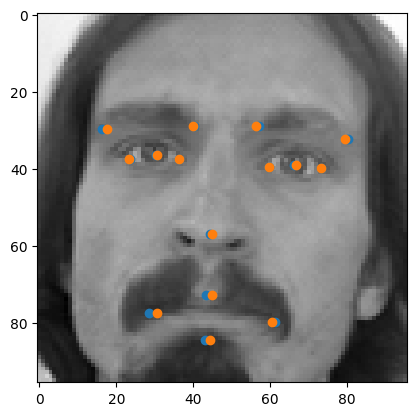

In [126]:
plt.imshow(x_full[0], cmap='grey')
y_pred = model(x_full[:1]).numpy()
key_points = y_full[0].reshape((-1, 2))
key_points_pred = y_pred[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.scatter(key_points_pred[:, 0], key_points[:, 1])
plt.show()

In [82]:
def fgsm(model, x, y, eps):
    delta = tf.Variable(tf.zeros_like(x))
    with tf.GradientTape() as tape:
        y_pred = model(x + delta)
        l = model.loss(y, y_pred)
    grad = tape.gradient(l, delta)
    return eps * tf.sign(grad)

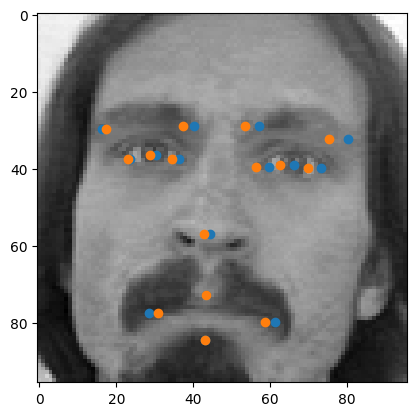

In [86]:
delta = fgsm(model, x_full[:1], y_full[:1], 0.01)

plt.imshow(x_full[0] + delta[0], cmap='grey')
y_pred = model(x_full[:1] + delta).numpy()
key_points = y_full[0].reshape((-1, 2))
key_points_pred = y_pred[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.scatter(key_points_pred[:, 0], key_points[:, 1])
plt.show()

In [84]:
def pgd(model, x, y, eps, alpha, n_iters):
    delta = tf.Variable(tf.zeros_like(x))

    @tf.function
    def train_step():
        with tf.GradientTape() as tape:
            y_pred = model(x + delta)
            l = model.loss(y, y_pred)
        grad = tape.gradient(l, delta)
        delta.assign_add(alpha * grad)
        delta.assign(tf.clip_by_value(delta, -eps, eps))
    

    for _ in range(n_iters):
        train_step()

    return delta.value()

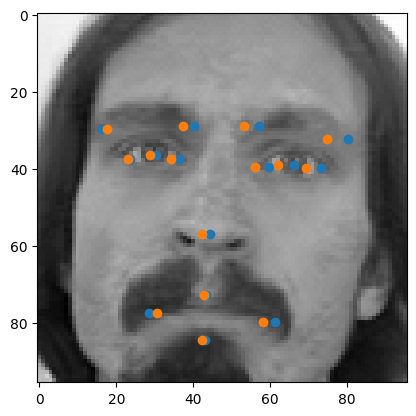

In [103]:
delta = pgd(model, x_full[:1], y_full[:1], 0.01, 0.001, 100)

plt.imshow(x_full[0] + delta[0], cmap='grey')
y_pred = model(x_full[:1] + delta).numpy()
key_points = y_full[0].reshape((-1, 2))
key_points_pred = y_pred[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.scatter(key_points_pred[:, 0], key_points[:, 1])
plt.show()